# Что надо сделать?
1. Для каждого доступного $\underline{европейского}$ опциона (со страйком и датой погашения) в каждый момент времени (допустим, в конце каждого дня), зная его цену, процентную ставку (ставку ФРС) и цену биткойна или эфира, находим $\sigma_{implied}$
2. Используем $\sigma_{implied}$ и находим цену американского опциона пут со страйком и датой погашения
3. находим хедж.
4. И так каждый день
5. А потом сравниваем результат с выплатой по опциону

Формула для подсчета хеджа $\delta \cdot S_{\frac{i}{365}} + (AP(i, T, K) - \delta \cdot S_{\frac{i-1}{365}})e^{rT}$
Дельту считаем из производной по нашей регрессии

# Вопросы
1) Параметры для модели БШ ($C$, $S_0$, $K$, $T$, $r$) правильно же я понимаю ведь цена базового актива на всех шагах не меняется что ли? - ежедневно обновляем цену базового дня
2) На втором шаге находим цену опциона через LongStaffSchwarz'a? Завтрашнюю цену? Какая дата погашения? (Равна дате погашения европейского опциона по которому сигму посчитали?) Со страйком та же история?   Да, Да, Та же, Да
3) Почему пут? Или просто для примера? - Потому что колл не выгодно == европ коллу
4) Почему делаем по всем доступным опционам? Чтобы посчитать среднюю ошибку алгоритма


# Как сделать?
1) Одношаговая модель по всем доступным опционам на сегодня
2) Учесть если дата экспирации сегодня то просто считаем выплату по опциону

In [3]:
import sys
import os

notebook_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(parent_dir)

# С какими проблемами столкнулся?
- Проблема с точностью прайсинга опционов при маленьких ценах 
- Проблема с датасетом, потому что не было привязок к ценам базовых активов (приходилось самостоятельно искать) и получались арбитражные возможности и их примерно 13% из датасета 
- Еще проблема с датасетом цены опционов иногда бывают равны 0 'ETH-29DEC23-600-P'
- При прогоне одношагового хеджирования алгоритм смог посчитать только 32.9 процентов данных из выборки на 10000 значений
- Повторяющиеся даты
- Во время подсчета подразумеваемой волатильности обнаружил что опцион (2023-06-01 08:00:00, ETH-29DEC23-5500-P) не мог подобрать волатильность нормально и все время уходил в бесконечность не смотря на то что цена опциона почти не менялась (используя БШ) - поэтому принял решение поставить максимальную границу волатильности в 1000% 
 

# TODO: Разобраться с тем как правильно высчитывать дельту, так же посмотреть на то как я везде дисконтирую

In [1]:
import pandas as pd
import warnings
from hedge.find_hedge import FindHedge
from hedge.option_schema import OptionSchema
from hedge.implied_volatility import ImpliedVolatility
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

### Здесь я уже подчистил данные

In [2]:
data = pd.read_csv('../data/server_data/dataset_cleaned.csv', index_col='Unnamed: 0')

data.drop_duplicates(subset=['id', 'dttm'])

data

,dttm,id,price,S,r,S_prev
44342,2023-11-24 08:00:00,BTC-15DEC23-19000-P,3.729632,37296.316406,0.05,37826.105469
44343,2023-11-25 08:00:00,BTC-15DEC23-19000-P,3.772141,37721.414063,0.05,37296.316406
44344,2023-11-26 08:00:00,BTC-15DEC23-19000-P,3.779683,37796.828125,0.05,37721.414063
44345,2023-11-27 08:00:00,BTC-15DEC23-19000-P,3.745419,37454.191406,0.05,37796.828125
44346,2023-11-28 08:00:00,BTC-15DEC23-19000-P,3.724799,37247.992188,0.05,37454.191406
...,...,...,...,...,...,...
574446,2024-02-29 08:00:00,ETH-8MAR24-4000-C,8.467007,3386.802734,0.05,3243.893311
603020,2024-02-29 08:00:00,ETH-8MAR24-4000-C,8.467007,3386.802734,0.05,3243.893311
574447,2024-03-01 08:00:00,ETH-8MAR24-4000-C,12.031077,3341.965820,0.05,3386.802734
603021,2024-03-01 08:00:00,ETH-8MAR24-4000-C,12.031077,3341.965820,0.05,3386.802734


In [36]:
data = data.sort_values(by=["id", "dttm"])

# Насемплим данных
random_250_options = np.random.choice(data['id'].unique(), size=250, replace=False)

sample = data[data['id'].isin(random_250_options)].to_dict('records')

In [37]:
def dynamical_delta_hedging(data: list):
    results = {}
    num_of_step = 0
    hedge_prev = None
    delta_prev = None
    
    for el in tqdm(data):
        try:
            option = OptionSchema.model_validate(el)
            
            # Пропускаем опционы у которых цена == 0
            if option.option_price == 0:
                continue
                
            # Если опциона нет в списке валидации то мы создаем массив для него чтобы его начать вычислять
            if option.full_name not in results.keys():
                results[option.full_name] = []
                num_of_step = 0
                hedge_prev = None
                delta_prev = None
            
            implied_volatility_algo = ImpliedVolatility(option=option)
            find_hedge = FindHedge(
                option=option,
                implied_volatility=implied_volatility_algo
            )    
    
            hedge_now, delta_now, american_option_price, implied_volatility = find_hedge.run(
                step_num=num_of_step,
                hedge_prev=hedge_prev,
                delta_prev=delta_prev,
                num_simulations=1000
            )
                
            results[option.full_name].append(
                {
                    "date": el['dttm'],
                    "hedge": hedge_now,
                    "delta": delta_now, 
                    "spot_price": option.spot_price,
                    "AP_price" : american_option_price,
                    "strike": option.strike,
                    "IV": implied_volatility,
                }
            )
            
            hedge_prev = hedge_now
            delta_prev = delta_now
            num_of_step += 1
            
        except KeyboardInterrupt:
            return results
            
        except Exception as e:
            if str(e) == "expected non-empty vector for x":
                continue
            else:
                print(e)
                continue
                
    return results


In [ ]:
results = dynamical_delta_hedging(sample)

  0%|          | 0/37645 [00:00<?, ?it/s]

In [ ]:
import pickle 

with open('hedge_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [3]:
def hedge_vs_option_price(option_info):
    for situation in option_info:
        situation['hedge_vs_option_price'] = situation['hedge'] - situation['AP_price']
    return option_info

def hedge_vs_debt(option_info):
        return max((option_info['strike'] - option_info['spot_price']) - option_info['hedge'], 0)


def vizualize_errors(first_step_error: list, max_error_in_option: list, bins=50, figsize=(12, 8)):
    
    if len(first_step_error) != 0 or len(max_error_in_option) != 0:
    
        ig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        
        fe = [el['error'] for el in first_step_error]
        me = [el['error'] for el in max_error_in_option]
    
        ax[0].hist(fe, bins=bins)
        ax[0].set_xlabel('Ошибка')
        ax[0].set_ylabel('Кол-во элементов с этой ошибкой')
        ax[0].set_title(f"Распредление ошибки {first_step_error[0]['opt_name'][:3]} на первом шаге")
        
        ax[1].hist(me, bins=bins)
        ax[1].set_xlabel('Ошибка')
        ax[1].set_ylabel('Кол-во элементов с этой ошибкой')
        ax[1].set_title(f"Распредление максимальной ошибки {first_step_error[0]['opt_name'][:3]} во время хеджирования опциона")
        
        plt.tight_layout()
        plt.show()
    else:
        print("No errors found")

In [5]:
import pickle
with open('hedge_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Распредление ошибки на первом шаге и максимальная ошибка
- Error: max((K - S_now) - hedge, 0)
- Distribution hist of error array

In [6]:
first_step_error = []
max_error_in_option = []

trace_anomaly_errors = []

for name, data in results.items():
    errors_list = []
    
    for i in range(len(data)):
        if i == 1:
            first_step_error.append({"opt_name" : name, "params": data[i], "error": hedge_vs_debt(data[i])})
            
        errors_list.append({"opt_name" : name, "params": data[i], "error": hedge_vs_debt(data[i])})
    if len(errors_list) == 0:
        continue
        
    else:    
        erl = [el['error'] for el in errors_list]
        index_of_error = erl.index(max(erl))
        max_error_el = {
            "opt_name" : name,
            "error" : max([el['error'] for el in errors_list]),
            "params": errors_list[index_of_error]['params']
        }
    
        max_error_in_option.append(max_error_el)  
        errors_list = []

Разделяем на BTC/ETH

In [7]:
eth_first_step_error = [el for el in first_step_error if el['opt_name'][:3] == 'ETH']
btc_first_step_error = [el for el in first_step_error if el['opt_name'][:3] == 'BTC']

eth_max_error_in_option = [el for el in max_error_in_option if el['opt_name'][:3] == 'ETH']
btc_max_error_in_option = [el for el in max_error_in_option if el['opt_name'][:3] == 'BTC']

assert len(max_error_in_option) == len(eth_max_error_in_option) + len(btc_max_error_in_option)
assert len(first_step_error) == len(eth_first_step_error) + len(btc_first_step_error)

print(f"ETH len {len(eth_first_step_error)}\nBTC len {len(btc_first_step_error)}")

ETH len 75
BTC len 118


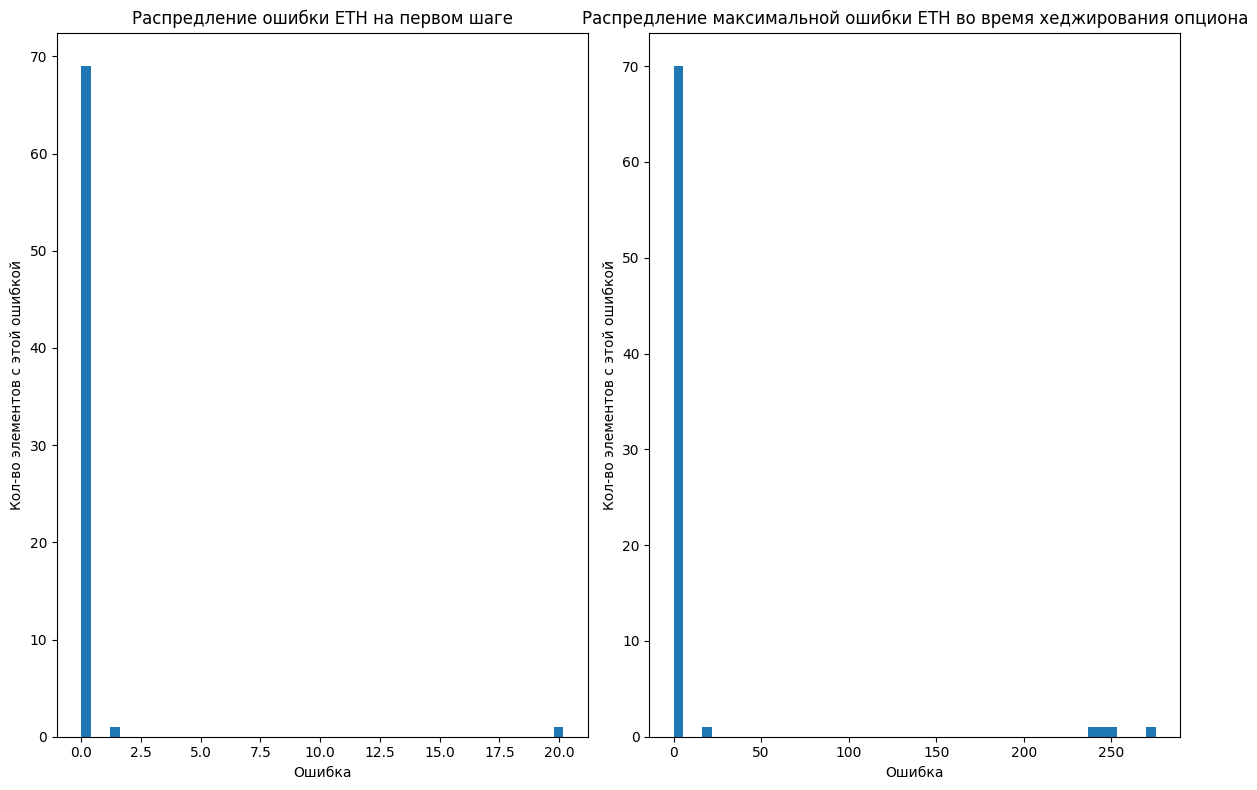

First step error: sigma 2.37993490051754, E 0.30490690415151644, 0.95-quantile 0.0
Max error: sigma 56.95197988488197, E 13.7910994648831, 0.95-quantile 86.37762309570472


In [22]:
f_eth_first_step_error = [el for el in eth_first_step_error if el['error'] < 200]
f_eth_max_error_in_option = [el for el in eth_first_step_error if el['error'] < 50000]

vizualize_errors(f_eth_first_step_error, f_eth_max_error_in_option)

errors_1 = np.array([el['error'] for el in f_eth_first_step_error])
errors_2 = np.array([el['error'] for el in f_eth_max_error_in_option])

print(f"First step error: sigma {errors_1.std()}, E {errors_1.mean()}, 0.95-quantile {np.quantile(errors_1, 0.95)}")
print(f"Max error: sigma {errors_2.std()}, E {errors_2.mean()}, 0.95-quantile {np.quantile(errors_2, 0.95)}")

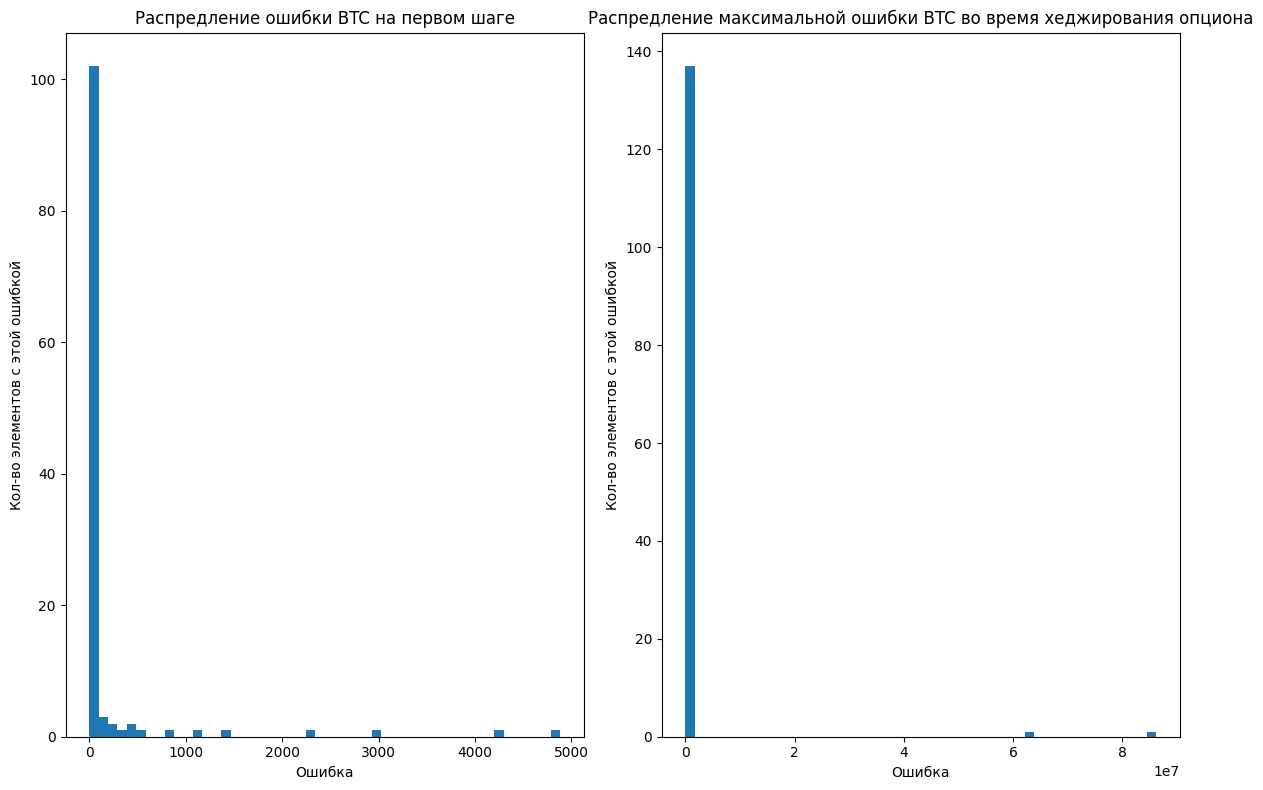

First step error: sigma 696.7360814001723, E 175.61603384582634, 0.95-quantile 862.6865029613951
Max error: sigma 8966196.541645981, E 1079890.6845600787, 0.95-quantile 88929.37493333964


In [17]:
vizualize_errors(btc_first_step_error, btc_max_error_in_option)

errors_1 = np.array([el['error'] for el in btc_first_step_error])
errors_2 = np.array([el['error'] for el in btc_max_error_in_option])

print(f"First step error: sigma {errors_1.std()}, E {errors_1.mean()}, 0.95-quantile {np.quantile(errors_1, 0.95)}")
print(f"Max error: sigma {errors_2.std()}, E {errors_2.mean()}, 0.95-quantile {np.quantile(errors_2, 0.95)}")

In [ ]:
"""
EXAMPLE OF RESULT EL

{
    "ETH-30NOV23-1750-P": [
        {
            "date": "2020-05-21",
            "hedge": "SOME_FLOAT",
            "delta": "SOME_FLOAT", 
            "spot_price": "SOME_FLOAT",
            "AP_price" : "SOME_FLOAT",
            "strike": "SOME_FLOAT",
            "IV": "SOME_FLOAT", 
        }
    ]
}
"""